# Likelihood Analysis of Parameter space
This notebook contains analysis regarding the Likelihood of various parameter combinations.

- Do Maximum Likelihood analysis (with Nelder Mead)
- Parallelize

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import os as os
import multiprocessing as mp
import sys as sys
import socket
import h5py  # Python Package to do the HDF5.
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Need: Parallel, quick computation of likelihoods for target individuals
Problem: Bottleneck is I/O. I.e. load the 100 TSI individuals once - and then just update the parameters and recalculate

### Game Plan:
Have the 100 TSI individuals in memory in a pre-loaded hmm Object

In [3]:
def prep_hmm_object(path_mosaic, exclude_pops, iid, prefix_out="", ch=3, n_ref=503, diploid=True):
    """Prepare and return a working HMM object
    diploid: Whether to shuffle diploid observations."""
    
    hmm = HMM_Analyze(cython=2, p_model="MosaicHDF5",
                      manual_load=True, save=False, save_fp=False, output=False)
    hmm.load_preprocessing_model()              # Load the preprocessing Model
    hmm.p_obj.set_folder(path_mosaic)         # Set the Folder
    hmm.p_obj.set_params(destroy_phase=diploid, prefix_out_data=prefix_out,
                        excluded=exclude_pops)
    ### DELETE when run for with European Reference!!
    hmm.p_obj.set_params(h5_path1000g = "./Data/1000Genomes/HDF5/1240kHDF5/all1240/chr", 
                         meta_path_ref = "./Data/1000Genomes/Individuals/meta_df_all.csv")
    
    hmm.load_data(iid=iid, ch=ch, n_ref=n_ref)  # Load the actual Data
    
    ### Emission and Transition Model
    hmm.load_secondary_objects()
    #hmm.load_emission_model()
    #hmm.load_transition_model()
    
    ### Set the Parameters
    #hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump)
    #hmm.e_obj.set_params(e_rate = e_rate)
    
    return hmm

def ll_mosaic_individual(hmm, roh_in=1, roh_out=10, roh_jump=100, e_rate=0.001):
    """Calculate the Log Likelihood of Mosaic Individual"""    
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump)
    hmm.e_obj.set_params(e_rate = e_rate)
    
    _, _, _, tot_ll = hmm.calc_posterior(save=False, full=True)
    return tot_ll

def ll_mosaic_individual(prms):
    """Calculate the log likelihood of Mosaic individual.
    ASSUME THAT HMM (hmm) IS INITIALIZED PROPERLY!!!"""
    roh_in, roh_out, roh_jump = prms
    print("\nParameters Current Step:")
    print(f"ROH In {roh_in:.3f}")
    print(f"ROH Out {roh_out:.3f}")
    print(f"ROH Jump: {roh_jump:.3f}")
    
    if np.min(prms)<0:   # If Parameter not feasible, penalize
        return np.inf
    
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump) # Set the Parameters
    _, _, _, tot_ll = hmm.calc_posterior(save = False, full = True)  # Calculate the LL
    
    print(f"LL: {tot_ll:.6f}")
    return -tot_ll  # Return Negetive one (for minimization)

# Pilot: Test one individual

### Load HMM Object

In [12]:
%%time
iid = "iid0"
ch=3
n_ref=2504
path_mosaic = "./Simulated/1000G_Mosaic/TSI5/ch3_8cm/"
exclude_pops = ["TSI", ]

### Prepare HMM Object
hmm = prep_hmm_object(path_mosaic, exclude_pops=exclude_pops, iid = iid, ch=ch, n_ref=n_ref)


Loaded 77652 variants
Loaded 100 individuals
HDF5 loaded from ./Simulated/1000G_Mosaic/TSI5/ch3_8cm/data.h5

Loaded 77652 variants
Loaded 2504 individuals
HDF5 loaded from ./Data/1000Genomes/HDF5/1240kHDF5/all1240/chr3.hdf5
2397 / 2504 Individuals included in Reference
CPU times: user 1min, sys: 886 ms, total: 1min
Wall time: 1min


In [13]:
%%time
### Test the log likelihood evaltions
#ll = ll_mosaic_individual(hmm, roh_in=1, roh_out=10, roh_jump=100)
ll = ll_mosaic_individual([1,10,100])
ll   # In Original: Is 24388.063


Parameters Current Step:
ROH In 1.000
ROH Out 10.000
ROH Jump: 100.000
Memory Usage: 4267.25376 mB
Reference Number: 4794
Total Log likelihood: -25344.831
Memory Usage: 4267.7248 mB
LL: -25344.830545


25344.830545396668

## Optimize Single Individual Function

In [ ]:
x0 = np.array([5, 10, 500])  # The Starting Value
res = minimize(ll_mosaic_individual, x0, method='nelder-mead', options={'fatol': 1e-2, 'disp': True})

# Optimize LL for TSI copies (Parallelization)
Idea: Have array of hmms [hmm, hmm1, ... ]. The LL Function updates the jump parameters, and calculates the total ll in parallel

### 1) Load HDF5

In [3]:
h5_path = "Simulated/1000G_Mosaic/CHB0/ch3/data.h5"  ### Which HDF to look into
f = h5py.File(h5_path, "r") # Load for Sanity Check. See below!
samples = f["samples"][:]

print(f"Loaded {len(samples)} targets")

Loaded 103 targets


### 2) Prepare HMM Object vector hmms

In [ ]:
%%time
n_lls = 20 # How many Individuals to use from target
ch=3
n_ref=2504  # 503
path_mosaic = "./Simulated/1000G_Mosaic/CHB0/ch3/"
exclude_pops = ["TSI", ]

### Load all TSI hmm workers
hmms = [prep_hmm_object(path_mosaic, exclude_pops=exclude_pops, iid=iid, 
                        ch=ch, n_ref=n_ref) for iid in samples[:n_lls]]

## Key Functions for Paralleliazation

In [4]:
### Some Functions for Printing of output
org_print = sys.stdout
def blockPrint():
    """Block Printing to Console"""
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    """Reanable Printing to Console"""
    sys.stdout = org_print

### Likelihood Functions
def ll_worker(hmm, roh_in, roh_out, roh_jump, e_rate=0.001):
    """Update Parameters, and calculate Likelihood for worker hmm"""
    hmm.t_obj.set_params(roh_in=roh_in, roh_out=roh_out, roh_jump=roh_jump) # Set the Parameters
    hmm.e_obj.set_params(e_rate = e_rate)                                   # Set error rates
    _, _, _, ll = hmm.calc_posterior(save = False, full = True)  # Calculate the LL
    return ll

def ll_mosaic_individuals(prms):
    """Calculate the log likelihood of Mosaic individual.
    ASSUME THAT hmms [:] array IS INITIALIZED PROPERLY!!!
    global parameter 'procses' determines number of parallel Processes"""
    roh_in, roh_out, roh_jump, e_rate = prms
    print("\nParameters Current Step:")
    print(f"ROH In {roh_in:.3f}")
    print(f"ROH Out {roh_out:.3f}")
    print(f"ROH Jump: {roh_jump:.3f}")
    print(f"Error Rate: {e_rate:.4f}")
    
    ### Return infinite value for infeasible params:
    if np.min(prms)<0:   
        return np.inf 
    
    ### Prepare the Parameter Array:
    arguments = [[hmm0, roh_in, roh_out, roh_jump, e_rate] for hmm0 in hmms]
    
    
    ### Do the Multiprocessing
    blockPrint()
    ll_vec = multi_run(ll_worker, arguments, procses)
    enablePrint()
    
    tot_ll = np.sum(ll_vec)
    print(f"Mean LL: {np.mean(ll_vec)}")
    print(f"STD LL: {np.std(ll_vec)}")
    print(f"Sum LL: {tot_ll:.8f}")
    
    return -tot_ll  # Return Negetive one (for minimization)

def multi_run(fun, prms, processes = 4):
    """Implementation of running in Parallel.
    fun: Function
    prms: The Parameter Files
    processes: How many Processes to use"""
    print(f"Running {len(prms)} jobs in parallel.")
    
    with mp.Pool(processes = processes) as pool:
        results = pool.starmap(fun, prms)
    return results

In [ ]:
%%time
### Run the Optimization (hmms array needs to be initialized!!)
procses = 10 ### How many processes in parallel 

x0 = np.array([2500, 2500, 200])  # The Starting Value (chosen according to single run)
res = minimize(ll_mosaic_individuals, x0, method='nelder-mead', options={'fatol': 1e-1, 'disp': True})

# Make LL PLot for multiple phased individuals and range of Parameters

In [20]:
def create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/TSI0/ch3/", n_lls=20, ch=3, n_ref=503, 
                    exclude_pops = ["TSI", ], processes=10, diploid=False):
    """Create the LL Curve for set of parameters.
    prms_vec: Vector of Parameters for HMM (ROH_in, ROH_out, ROH_jump, E_Rate)
    path_mosaic: Which Folder to load h5 from
    n_lls: How many individuals to use from target
    ch: Chromosome
    n_ref: How many references to use
    Return array of LL
    processes: How many Processes to use
    diploid: Whether to scramble the Target Genotypes"""
    global hmms # Use the global Parameter
    global procses # Use the global Processes Parameter
    
    procses = processes
    
    assert(len(prms_vec[0])==4)  ## Sanity Check whether right Number of Parameters given

    f = h5py.File(path_mosaic + "data.h5", "r") # Load for Sanity Check. See below!
    samples = f["samples"][:]
    print(f"Loaded {len(samples)} targets")
    
    ### 2) Prepare hmms worker array
    hmms = [prep_hmm_object(path_mosaic, exclude_pops=exclude_pops, iid=iid, ch=ch, n_ref=n_ref, diploid=diploid) for iid in samples[:n_lls]]
    
    ### Do the Calculation for the
    ll_vec = [-ll_mosaic_individuals(prms) for prms in prms_vec]  # Calculate full LL vector
    return ll_vec

def plot_ll_curve_roh_jumps(roh_jumps, ll_vec1, title="", savepath="", ylim=[-5000,200]):
    """Plot Likelihood curve.
    roh_jumps: x_array
    ll_vec1: Likelihood Value Array
    savepath: If given, save the figure there"""
    fs = 18
    true_val = 0.1

    ll_vec = np.array(ll_vec1)
    ll_plot = ll_vec - np.max(ll_vec)
    i = np.argmax(ll_plot)

    print(f"Maximum Likelihood at {roh_jumps[i]} : {ll_vec[i]}")

    plt.figure(figsize=(8,6))
    plt.plot(roh_jumps, ll_plot, "o-", color="maroon", label="Data")
    plt.xscale("log")
    plt.ylabel("Log Likelihood", fontsize=fs)
    plt.xlabel("ROH Jump Probability", fontsize=fs)
    #plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
    #plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
    plt.legend(fontsize=fs*0.8)
    plt.ylim(ylim)
    plt.title("LogLikelihood ROH Jump phased 20 TSI")
    
    if len(title)>0:  # Set Title if given
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

    plt.show()

In [ ]:
roh_jumps = np.logspace(2.2, 3.5, 30)
prms_vec = [[1000, 1, rj, 0.01] for rj in roh_jumps]

ll_vec_tsi = create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/TSI0/ch3/", 
                         n_lls=20, ch=3, n_ref=503, exclude_pops=["TSI", ], processes=10, diploid=False)

### Do the Plot 
LL of 20 TSI indivdiuals (phased) with Ref rest of EUR 1000 Genomes

Maximum Likelihood at 361.9267555526093 : -102079.23094383568
Successfully saved to ./figures_test/ll_curve_ROH_jump_20phasedTSI_e01_rohin1000.pdf


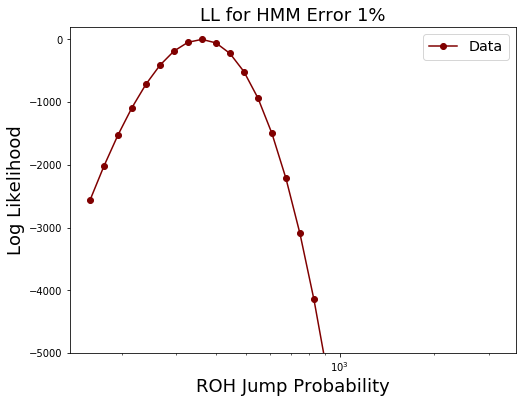

In [17]:
plot_ll_curve_roh_jumps(roh_jumps, ll_vec_tsi, title="LL for HMM Error 1%", savepath = "./figures_test/ll_curve_ROH_jump_20phasedTSI_e01_rohin1000.pdf")

## Run and Plot LL curve for phased TSI with full 2504 1000G Reference Dataset

In [ ]:
roh_jumps = np.linspace(200, 400, 10)
prms_vec = [[1000, 1, rj, 0.01] for rj in roh_jumps]

ll_vec_tsi_all = create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/TSI0/ch3/", 
                         n_lls=10, ch=3, n_ref=2504, exclude_pops=["TSI", ], processes=4, diploid=False)

Maximum Likelihood at 266.66666666666663 : -51615.40140454957


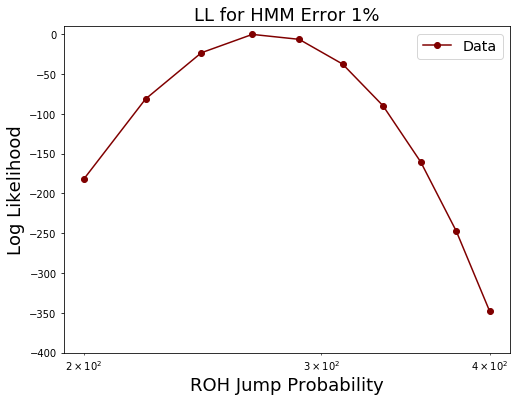

In [24]:
plot_ll_curve_roh_jumps(roh_jumps, ll_vec_tsi_all, title="LL for HMM Error 1%", 
                        savepath = "", ylim=[-400,10])

In [13]:
### Save to CSV:
# 1) Create Pandas Dataframe
df_save = pd.DataFrame({"Jump Rate":roh_jumps , "LL":ll_vec_tsi_all}) 
# 2) Save to .csv
savepath = "./Diverse/ll_10TSI_allHGref_200_400jump.csv"
df_save.to_csv(savepath)
print(f"Successfully saved to: {savepath}")

## Plot different Populations: TSI, CHB, CLM, YRI

In [19]:
roh_jumps = np.logspace(2.2, 3.5, 30)
prms_vec = [[1000, 1, rj, 0.01] for rj in roh_jumps]

#ll_vec_tsi = create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/TSI0/ch3/", 
#                         n_lls=20, ch=3, n_ref=503, exclude_pops=["TSI", ], processes=10, diploid=False)

In [ ]:
ll_vec_chb = create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/CHB0/ch3/", 
                         n_lls=20, ch=3, n_ref=503, exclude_pops=["TSI", ], processes=10, diploid=False)

Hello? Blizzard?
Maximum Likelihood at 493.29129118659574 : -145388.64232510407


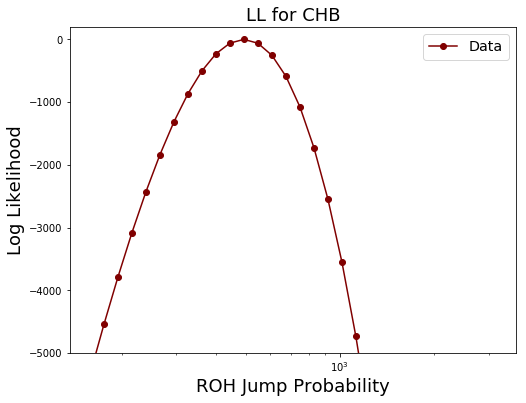

In [26]:
print("Hello? Blizzard?")
plot_ll_curve_roh_jumps(roh_jumps, ll_vec_clm, title="LL for CHB", savepath = "")

In [ ]:
ll_vec_yri = create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/YRI0/ch3/", 
                         n_lls=20, ch=3, n_ref=503, exclude_pops=["TSI", ], processes=10, diploid=False)

In [ ]:
ll_vec_clm = create_ll_curve(prms_vec, path_mosaic = "./Simulated/1000G_Mosaic/CLM0/ch3/", 
                         n_lls=20, ch=3, n_ref=503, exclude_pops=["TSI", ], processes=10, diploid=False)

### Make curves for different Target Population LLs within one Plot

In [37]:
def plot_ll_curve_roh_jumps_diffpops(roh_jumps, ll_vecs, pops, title="", savepath=""):
    """Plot Likelihood curve.
    roh_jumps: x_array
    ll_vec1: 2D Likelihood Value Array [n_pops, n_ll]
    savepath: If given, save the figure there"""
    fs = 18
    
    ### Get Colors for pops
    cmap = cm.get_cmap("viridis_r")
    colors = [cmap(x) for x in np.linspace(0,1, len(pops))]

    plt.figure(figsize=(8,6))
    
    for i, pop in enumerate(pops):
        m = np.argmax(ll_vecs[i,:])
        print(f"Maximum Likelihood at {roh_jumps[m]} : {ll_vecs[i,m]}")
        
        ll_plot = ll_vecs[i,:] - np.max(ll_vecs[i,:])
        plt.plot(roh_jumps, ll_plot, "o-", color=colors[i], label=pop)
        
    plt.xscale("log")
    plt.ylabel("Log Likelihood", fontsize=fs)
    plt.xlabel("ROH Jump Probability", fontsize=fs)
    #plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
    #plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
    plt.legend(fontsize=fs*0.8, title="Population", loc="lower left")
    plt.ylim([-5000,200])
    
    if len(title)>0:  # Set Title if given
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

    plt.show()

Maximum Likelihood at 361.9267555526093 : -102079.23094383568
Maximum Likelihood at 1016.0066528271416 : -176147.77810889482
Maximum Likelihood at 493.29129118659574 : -145388.64232510407
Maximum Likelihood at 3162.2776601683795 : -488397.7436666071


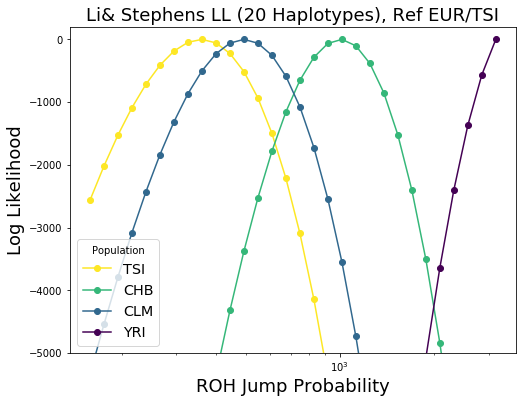

In [38]:
pops = ["TSI", "CHB", "CLM", "YRI"]
ll_vecs = np.array([ll_vec_tsi, ll_vec_chb, ll_vec_clm, ll_vec_yri])

plot_ll_curve_roh_jumps_diffpops(roh_jumps, ll_vecs, pops, title ="Li& Stephens LL (20 Haplotypes), Ref EUR/TSI")

# Test different Error Rates for ML Parameter

In [ ]:
%%time
### 3) Calculate LL for array of ROH Jump Rates
err_vec = np.logspace(-4,-1, 20)
prms_vec = [[1000, 1, 350, e] for e in err_vec]

procses = 10 # On Cluster
ll_vec_error = [-ll_mosaic_individuals(prms) for prms in prms_vec]  # Calculate full LL vector

In [18]:
def plot_ll_curve_errors(error_vec, ll_vec1, title="", savepath="", ylim = [-5000,200]):
    """Plot Likelihood curve."""
    fs = 18
    true_val = 0.1

    ll_vec = np.array(ll_vec1)
    ll_plot = ll_vec - np.max(ll_vec)
    i = np.argmax(ll_plot)

    print(f"Maximum Likelihood at {error_vec[i]} : {ll_vec[i]}")

    plt.figure(figsize=(8,6))
    plt.plot(error_vec, ll_plot, "o-", color="maroon", label="Data")
    plt.xscale("log")
    plt.ylabel("Log Likelihood", fontsize=fs)
    plt.xlabel("Error Rate", fontsize=fs)
    #plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
    #plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
    plt.legend(fontsize=fs*0.8)
    plt.ylim(ylim)
    plt.title("LogLikelihood for Li & Stephens of 20 TSI")
    
    if len(title)>0:  # Set Title if given
        plt.title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

    plt.show()

Maximum Likelihood at 0.00029763514416313193 : -90213.50426581407


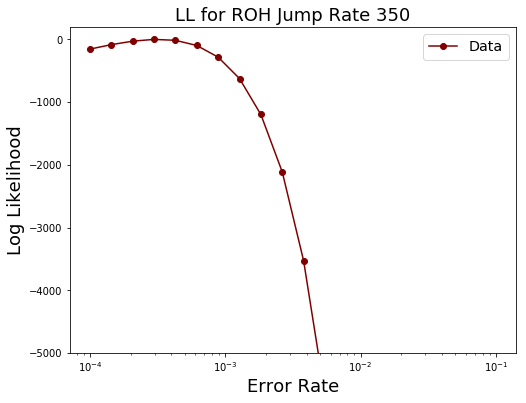

In [20]:
plot_ll_curve_errors(err_vec, ll_vec_error, title="LL for ROH Jump Rate 350", savepath="")

# Area51

### Plot of LL Copying with unphased data 
(should be much lower LL and peak at higher ROH-Jump)

Maximum Likelihood at 379.26901907322497 : -91102.36189653994
Maximum Likelihood at 1000.0 : -568815.9494010495


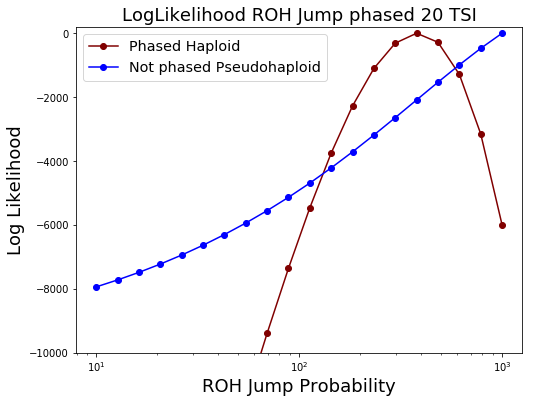

In [32]:
fs = 18
true_val = 0.1

ll_plot = ll_vec - np.max(ll_vec)
ll_plot1 = ll_vec1 - np.max(ll_vec1)
i = np.argmax(ll_plot)
i1 = np.argmax(ll_plot1)

print(f"Maximum Likelihood at {roh_jumps[i]} : {ll_vec[i]}")
print(f"Maximum Likelihood at {roh_jumps[i1]} : {ll_vec1[i]}")

plt.figure(figsize=(8,6))
plt.plot(roh_jumps, ll_plot, "o-", color="maroon", label="Phased Haploid")
plt.plot(roh_jumps, ll_plot1, "o-", color="blue", label="Not phased Pseudohaploid")

plt.xscale("log")
plt.ylabel("Log Likelihood", fontsize=fs)
plt.xlabel("ROH Jump Probability", fontsize=fs)
#plt.axvline(x=0.1, linewidth=3, color="lawngreen", label="True Value")
#plt.axhline(y=-2, label="LL=-2", color="gray", zorder=0)
plt.legend(fontsize=fs*0.8)
plt.ylim([-10000,200])
plt.title("LogLikelihood ROH Jump phased 20 TSI", fontsize=fs)
#plt.savefig("../figures_test/ll_curveSardX.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()